In [1]:
!git clone https://github.com/qhungngo/EVBCorpus.git

Cloning into 'EVBCorpus'...
remote: Enumerating objects: 35, done.
remote: Total 35 (delta 0), reused 0 (delta 0), pack-reused 35 (from 1)
Receiving objects: 100% (35/35), 35.37 MiB | 51.89 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [2]:
!apt install unrar > /dev/null

In [3]:
!unrar x -inul /kaggle/working/EVBCorpus/EVBCorpus_EVBNews_v2.0.rar /kaggle/working/data/

In [4]:
!ls "/kaggle/working/data" | head -3

N0001.sgml
N0002.sgml
N0003.sgml
ls: write error: Broken pipe


In [5]:
!pip install beautifulsoup4

In [6]:
from bs4 import BeautifulSoup
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

In [7]:
en, vi = [], []
for filename in os.listdir('/kaggle/working/data/'):
    with open(os.path.join('/kaggle/working/data/', filename), 'r') as f:
        doc = f.read()
    doc = BeautifulSoup(doc)
    text = [f'<eos> {tag_text.get_text()} <sos>' for tag_text in doc.find_all('s')]
    for i in range(0, len(text), 2):
        en.append(text[i])
        vi.append(text[i+1])

In [8]:
print(f"Length of data: {len(en)}, {len(vi)}")
print(f'First sentence pair: "{en[0]}" --> "{vi[0]}"')

Length of data: 45308, 45308
First sentence pair: "<eos> Marking International Women 's Day <sos>" --> "<eos> Kỷ niệm ngày quốc tế phụ nữ <sos>"


In [9]:
en_train, en_test, vi_train, vi_test = train_test_split(en, vi, test_size=0.1, shuffle=True, random_state=42)

In [10]:
en_tokenizer = Tokenizer(num_words=15000, filters='', lower=False, oov_token='<oov>')
en_tokenizer.fit_on_texts(en_train)

In [11]:
vi_tokenizer = Tokenizer(num_words=15000, filters='', lower=False, oov_token='<oov>')
vi_tokenizer.fit_on_texts(vi_train)

In [12]:
print(f'Length of en vocab: {len(en_tokenizer.word_index)}, vi vocab: {len(vi_tokenizer.word_index)}')

Length of en vocab: 39046, vi vocab: 17482


In [13]:
print(en_tokenizer.word_index.get('<sos>'))
print(en_tokenizer.word_index.get('<eos>'))
print(vi_tokenizer.word_index.get('<sos>'))
print(vi_tokenizer.word_index.get('<eos>'))
print(vi_tokenizer.word_index.get('<oov>'))

3
2
3
2
1


In [14]:
en_train = en_tokenizer.texts_to_sequences(en_train)
vi_train = vi_tokenizer.texts_to_sequences(vi_train)

In [15]:
max_en_len, max_vi_len = 0, 0
for i in range(len(en_train)):
    max_en_len = max(max_en_len, len(en_train[i]))
    max_vi_len = max(max_vi_len, len(vi_train[i]))
print(f'Max en len: {max_en_len}')
print(f'Max vi len: {max_vi_len}')

Max en len: 130
Max vi len: 164


In [16]:
en_train = pad_sequences(en_train, maxlen=max_en_len, padding='post')
vi_train = pad_sequences(vi_train, maxlen=max_vi_len, padding='post')

In [17]:
def prepare_batch(en, vi):
    en = tf.convert_to_tensor(en)
    vi_inputs = tf.convert_to_tensor(vi[:, :-1])
    vi_labels = tf.convert_to_tensor(vi[:, 1:])
    return (en, vi_inputs), vi_labels

In [18]:
en_train, en_val, vi_train, vi_val = train_test_split(en_train, vi_train, test_size=0.1, shuffle=True, random_state=42)

In [19]:
BATCH_SIZE = 64
train_batches = tf.data.Dataset.from_tensor_slices((en_train, vi_train)).batch(BATCH_SIZE).map(prepare_batch)
val_batches = tf.data.Dataset.from_tensor_slices((en_val, vi_val)).batch(BATCH_SIZE).map(prepare_batch)

# Define components and transformer model

In [20]:
def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

In [21]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [22]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

In [23]:
class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

In [24]:
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [25]:
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [26]:
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x

In [27]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

In [28]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
              x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

In [29]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x

In [30]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                 d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [31]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=input_vocab_size,
                               dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x  = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [32]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
vocab_size = 15000

In [33]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=vocab_size,
    target_vocab_size=vocab_size,
    dropout_rate=dropout_rate)

In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
        return {
            'd_model': self.d_model.numpy(),
            'warmup_steps': self.warmup_steps,
        }

In [35]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [36]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [37]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [38]:
checkpoint = ModelCheckpoint(filepath='./model_checkpoint.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               restore_best_weights=True,
                               verbose=1)

In [39]:
history = transformer.fit(train_batches,
                epochs=100,
                validation_data=val_batches,
                callbacks=[checkpoint, early_stopping])

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/ke

573/574 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 8.8089 - masked_accuracy: 0.0423

W0000 00:00:1729267459.467554     127 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 8.8072 - masked_accuracy: 0.0423

W0000 00:00:1729267471.533584     128 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1729267476.937171     127 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 6.39253, saving model to ./model_checkpoint.keras
574/574 ━━━━━━━━━━━━━━━━━━━━ 169s 217ms/step - loss: 8.8056 - masked_accuracy: 0.0424 - val_loss: 6.3925 - val_masked_accuracy: 0.0964
Epoch 2/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 5.9434 - masked_accuracy: 0.1470
Epoch 2: val_loss improved from 6.39253 to 4.89602, saving model to ./model_checkpoint.keras
574/574 ━━━━━━━━━━━━━━━━━━━━ 105s 183ms/step - loss: 5.9427 - masked_accuracy: 0.1470 - val_loss: 4.8960 - val_masked_accuracy: 0.2551
Epoch 3/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 4.6276 - masked_accuracy: 0.2757
Epoch 3: val_loss improved from 4.89602 to 4.14736, saving model to ./model_checkpoint.keras
574/574 ━━━━━━━━━━━━━━━━━━━━ 105s 183ms/step - loss: 4.6272 - masked_accuracy: 0.2757 - val_loss: 4.1474 - val_masked_accuracy: 0.3267
Epoch 4/100
574/574 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 3.8926 - masked_accuracy: 0.3496
Epoch 4: val_loss improved from

In [40]:
transformer.save('./transformer.keras')

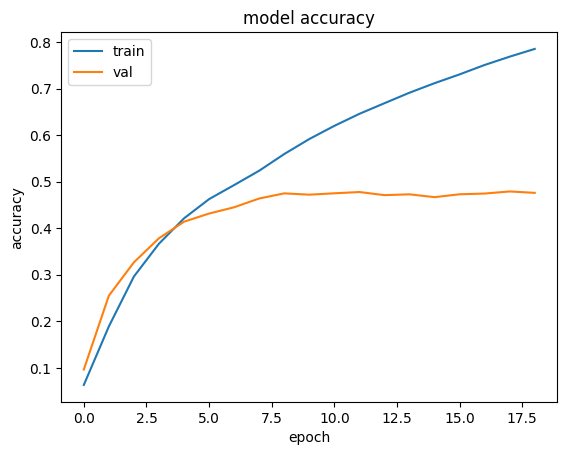

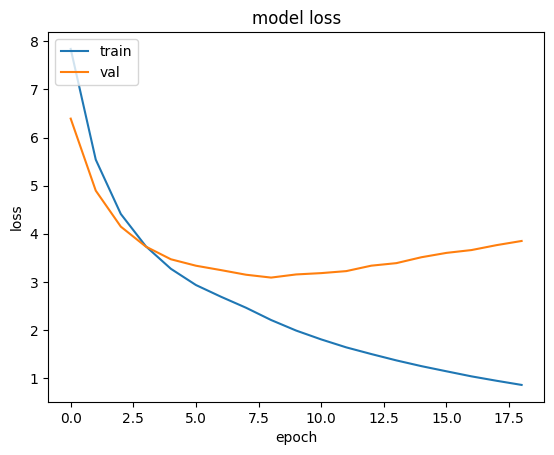

In [41]:
plt.plot(history.history['masked_accuracy'])
plt.plot(history.history['val_masked_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()